In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np



# Localized sandsnap texture generation from NAIP


Hypothesis:  VHR resolution satellite imagery (like NAIP) maybe good enough to see a correlation between image texture features (extracted from GLCMs) and sand grain size distribution


In this notebook, we extract median sand grain sizes (D50) from a single beach in NY, USA: Jones Beach. This beach has 52 observations spatially spread out across this beach taken in June 2021, and found in the file `data/sandsnap-jones-beach.csv`. Using the NAIP imagery from this beach, we will try to verify if there is a correlation b/w D50 and some GLCM features.

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [2]:
sandsnap_df = pd.read_csv('data/sandsnap-jones-beach.csv')
sandsnap_df['date'] =  pd.to_datetime(sandsnap_df['CreationDate'], format='%m/%d/%y',infer_datetime_format=True).dt.date
sandsnap_df.head()

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y,date
0,92,09288394-b8a9-4f39-8650-d4fb2bdcfae4,Jones Beach,Jb 25,quarter,the_dune,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.556896,40.580327,2021-06-11
1,115,00d44f58-5335-43f9-8e38-b0bd4f10fb59,Jones Beach,Jb 9,quarter,the_dune,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.569361,40.575935,2021-06-11
2,138,fb7c7c17-139f-44a0-8c0f-160d3e3ace7d,Jones Beach,Jb 46,quarter,the_swash,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.560789,40.578358,2021-06-11
3,132,33c8a80f-d87d-4ea8-8c03-d86c07e6be31,Jones Beach,Jb 52,quarter,the_swash,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.573119,40.574644,2021-06-11
4,109,6972547e-9e47-4aea-8e4c-f28363cc240a,Jones Beach,Jb 2,quarter,the_berm,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.573203,40.574809,2021-06-11


In [3]:
sandsnap_df.dtypes

objectid                                                                                   int64
GlobalID                                                                                  object
City                                                                                      object
Sample ID                                                                                 object
Coin Reference                                                                            object
Location on Beach                                                                         object
Other                                                                                     object
CreationDate                                                                              object
Creator                                                                                   object
EditDate                                                                                  object
Editor                        

### Convert to geopandas

In [4]:
jones_beach = sandsnap_df[['objectid','D50 mm','Processing Status','date','x','y']]
jones_beach = jones_beach[jones_beach['Processing Status'] == 'ok'].drop('Processing Status',axis='columns')
jones_beach = jones_beach.rename(columns={'D50 mm':'D50'}) #Rename the field
jones_beach.head()

,objectid,D50,date,x,y
0,92,3.595201,2021-06-11,-73.556896,40.580327
1,115,0.374309,2021-06-11,-73.569361,40.575935
2,138,0.466378,2021-06-11,-73.560789,40.578358
3,132,0.425205,2021-06-11,-73.573119,40.574644
4,109,0.635154,2021-06-11,-73.573203,40.574809


## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [5]:
side_len_deg = 0.001

In [6]:
def bbox(lon, lat, side_len_deg = 0.001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## Functions to extract NAIP tiles for each entry

In [7]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [8]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [22]:
def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def NAIP_tile(date, lon, lat, limit_months=48):
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    range_date = "2018-01-01/2023-01-03"
    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = stac.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["naip"],
        limit=5,
        #query={"eo:cloud_cover": {"lt": 25}},
    )

    items = search.item_collection()
    chosen_item = items[0]
    delta_days = abs((chosen_item.datetime.date() - date).days)
    
    if len(items) > 1:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                chosen_item = item
                
    #Make sure area of overlap is 100%
    assert(area_of_overlap(chosen_item,aoi) == 1)
    
    print("{:} overlapping tile(s) found for date range: {:}\nChosen tile with delta:{:} days"\
      .format(len(items),date_range,delta_days))
        
    return chosen_item   
        
        # chosen_item, aoo_max = items[0], 0.
        #Pick the tile that has the most amount of overlap with the coordinate patch
        # return sorted(items, key=area_of_overlap, reverse=True)[0]
    #     for i, item in enumerate(items):
    #         aoo = area_of_overlap(item, aoi)
    #         if aoo > aoo_max:
    #             aoo_max = aoo
    #             chosen_item = item
    #     return chosen_item
    # else:
    #     return items[0]
 
#Test it
tile = NAIP_tile(jones_beach['date'][0],jones_beach['x'][0],jones_beach['y'][0])


1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days


# Crop of AOI

Efficiently!

In [10]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [11]:
import shapely 
import rasterio
from rasterio.mask import mask


def get_rgbir_patch(rgbir_url, lon, lat, window_size=3):
    point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    PATCH_SIZE_M = 100.
    # side_length_m = 101. #meters because the destination EPSG (26916) is in meters

    with rasterio.Env():
        with rasterio.open(rgbir_url, "r") as f:
            point_geom = rasterio.warp.transform_geom(
                "epsg:4326", f.crs.to_string(), point_geom)

            #Convert the point to a shape
            point_shape = shapely.geometry.shape(point_geom)
            #Create a square out of it with side_length = buffer*2
            mask_shape = point_shape.buffer(PATCH_SIZE_M/2).envelope
            mask_geom = shapely.geometry.mapping(mask_shape)

            #crop to the aoi (mask)
            try:
                image_rgbir, _ = mask(
                    f, [mask_geom], crop=True)
                
                #Now crop to a smaller patch
                assert (window_size < image_rgbir.shape[1])
                img_rgbir_patch = cropCenter(image_rgbir, (image_rgbir.shape[0],window_size,window_size)) #4 for 4 channels
                return img_rgbir_patch

            except ValueError as e:
                if "Input shapes do not overlap raster." in str(e):
                    print ("no dice")
                    
                    
    


### Gray levels


Use of two methods to derive the gray levels from the 4 band image

In [20]:
def get_gray(img, method='mean'):
    """
    method:'mean' uses an average of all bands
    method:'weighted' uses known weights that maximuize human visual perception - probably not relevant for this task
    """
    
    gray = np.average(img, axis=0).astype('uint8') if method == 'mean' \
    else np.average(img, axis=0, weights=[0.3, 0.59, 0.11, 0.]).astype('uint8')
    
    return gray

## Haralick features

In [42]:
def get_haralick_features(gray, distance, properties):
    
    #Generate GLCM matrix
    glcm = graycomatrix(gray, distances=[distance], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)
    
    feature = []
    
    for prop in properties:
        p_i = graycoprops(glcm, prop)
        # print(p_i)
        p_i = np.average(p_i[0], axis=0)
        # print(p_i)
        feature.append(p_i)
        
    return feature
    

In [42]:
def get_haralick_features(gray, distance, prop):
    
    #Generate GLCM matrix
    glcm = graycomatrix(gray, distances=[distance], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)
    
    p_i = graycoprops(glcm, prop)
    return feature
    

## Pick most appropriate NAIP tile
Sort them by area of coverage

In [98]:
WINDOW_SIZE_M = 5
DISTANCE_PX = 2
DISTANCE_PX = 5
# DISTANCE_PX = 10
PROPERTIES = ['dissimilarity','homogeneity','contrast','energy','correlation']

# test = jones_beach.copy()

for prop in PROPERTIES:
    jones_beach[prop] = np.NaN


jones_beach.head()
    



,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,ASM,correlation,energy
0,92,3.595201,2021-06-11,-73.556896,40.580327,NaN,NaN,NaN,NaN,NaN,NaN
1,115,0.374309,2021-06-11,-73.569361,40.575935,NaN,NaN,NaN,NaN,NaN,NaN
2,138,0.466378,2021-06-11,-73.560789,40.578358,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0.425205,2021-06-11,-73.573119,40.574644,NaN,NaN,NaN,NaN,NaN,NaN
4,109,0.635154,2021-06-11,-73.573203,40.574809,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
import warnings
warnings.filterwarnings("ignore")

def get_haralick_features(df):
    """
    """
    for index, sample in df.iterrows():
        # print(row['D50'], row['date'])
        lon, lat = sample['x'], sample['y']
        tile = NAIP_tile(sample['date'], lon, lat)
        gsd = tile.properties['gsd'] 
        window_size_px = int(WINDOW_SIZE_M / gsd + 0.5)
        rgbir_url = tile.assets['image'].href

        #Extract patch of window_size_px around (lon,lat)
        patch = get_rgbir_patch(rgbir_url, lon, lat, window_size_px)

        #convert to grayscale
        gray = get_gray(patch)

        #get GLCM
        glcm = graycomatrix(gray, distances=[DISTANCE_PX], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                            symmetric=True, normed=False)

        #Get haralick features
        for prop in PROPERTIES:
            p = graycoprops(glcm, prop)
            p = np.average(p[0], axis=0)
            # print(p)
            df[prop].iloc[index] = p
    


In [100]:
get_haralick_features(jones_beach)
jones_beach.head()

1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
2 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
1 overlapping tile(s) found for date range: 2019-06-11/2023-06-11
Chosen tile with delta:672 days
2 overlapping tile(s

,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,ASM,correlation,energy
0,92,3.595201,2021-06-11,-73.556896,40.580327,0.994792,0.558854,1.557292,NaN,-0.403520,0.418288
1,115,0.374309,2021-06-11,-73.569361,40.575935,1.250000,0.504963,2.593750,NaN,-0.256925,0.380967
2,138,0.466378,2021-06-11,-73.560789,40.578358,9.359375,0.064824,111.796875,NaN,-0.211509,0.177922
3,132,0.425205,2021-06-11,-73.573119,40.574644,2.651042,0.296734,10.776042,NaN,0.017906,0.291550
4,109,0.635154,2021-06-11,-73.573203,40.574809,1.979167,0.357556,5.677083,NaN,-0.008228,0.304011


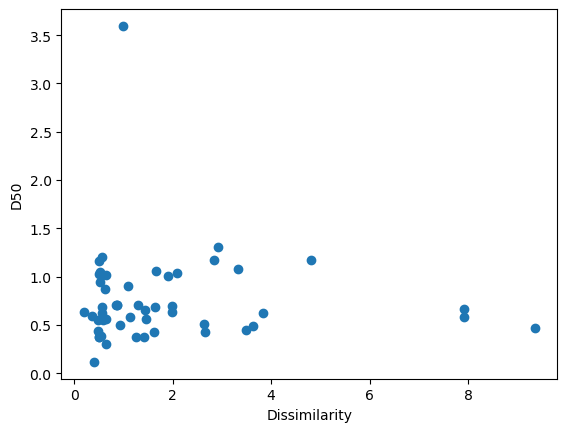

In [101]:
plt.scatter(jones_beach['dissimilarity'], jones_beach['D50'])
plt.xlabel('Dissimilarity')
plt.ylabel('D50')
plt.show()

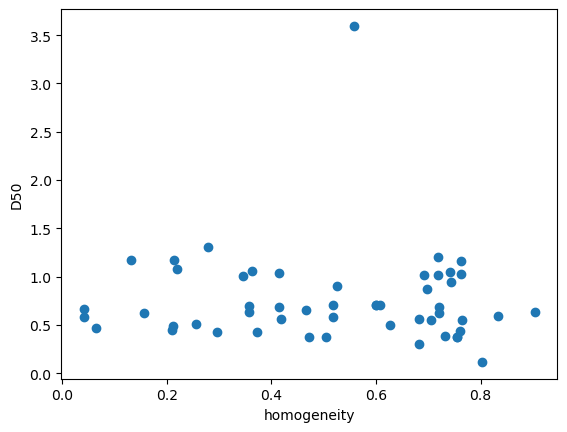

In [102]:
plt.scatter(jones_beach['homogeneity'], jones_beach['D50'])
plt.xlabel('homogeneity')
plt.ylabel('D50')
plt.show()

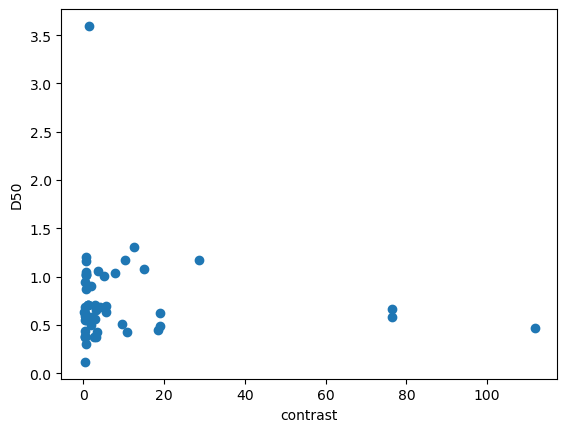

In [103]:
plt.scatter(jones_beach['contrast'], jones_beach['D50'])
plt.xlabel('contrast')
plt.ylabel('D50')
plt.show()

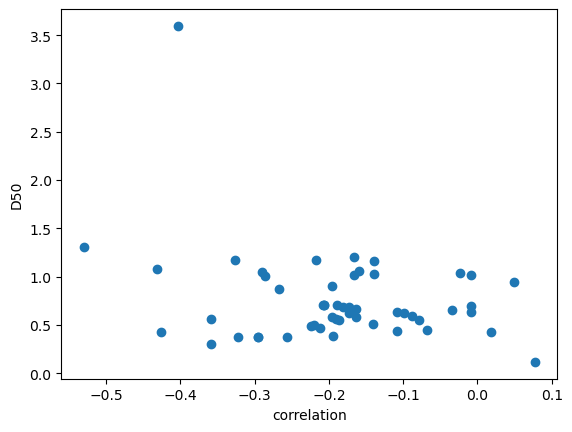

In [104]:
plt.scatter(jones_beach['correlation'], jones_beach['D50'])
plt.xlabel('correlation')
plt.ylabel('D50')
plt.show()

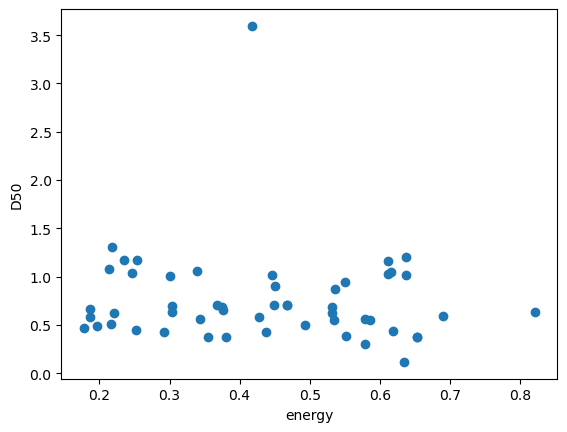

In [105]:
plt.scatter(jones_beach['energy'], jones_beach['D50'])
plt.xlabel('energy')
plt.ylabel('D50')
plt.show()

## Multiple regression

In [106]:
import statsmodels.formula.api as smf 

# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ dissimilarity + homogeneity + contrast + correlation + energy', data=jones_beach).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.328
Date:                Fri, 10 Mar 2023   Prob (F-statistic):              0.269
Time:                        22:56:53   Log-Likelihood:                -32.531
No. Observations:                  52   AIC:                             77.06
Df Residuals:                      46   BIC:                             88.77
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1177      1.238      0.095      0.925      -2.374       2.610
dissimilarity     0.2193      0.419      0.523      0.604      -0.625       1.063
homogeneity       2.1850      2.104      1.038      0.305      -2.051       6.421
contrast         -0.0149      0.027     -0.554      0.582      -0.069       0.039
correlation      -1.1968      0.553     -2.163      0.036      -2.311      -0.083
energy           -2.2230      1.579     -1.408      0.166      -5.401       0.955
==============================================================================
Omnibus:                       64.991   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.250
Skew:                           3.193   Prob(JB):                    2.51e-134
Kurtosis:                      18.594   Cond. No.                         915.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

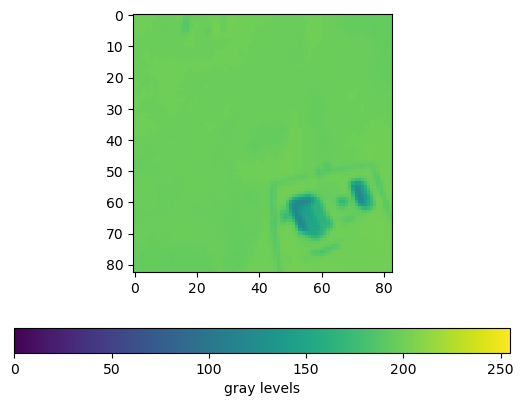

In [38]:
# img_rgb = np.dstack((patch[0], patch[1], patch[2]))  
# plt.imshow(img_rgb)
plt.imshow(gray,vmin=0, vmax=255)
plt.colorbar(label="gray levels", orientation="horizontal")
plt.show()

In [24]:
item.assets['image']

NameError: name 'item' is not defined

Extract resolution in m/px

In [233]:
item.properties['proj:epsg']

26918

## Visualize the entire NAIP tile

In [11]:
from IPython.display import Image

Image(url=tile.assets["rendered_preview"].href)

4-channel numpy array

In [21]:
image_rgbir.shape

(4, 168, 168)

## Display the cropped patch

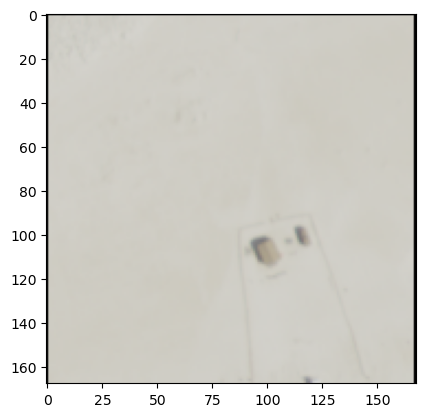

In [22]:
import matplotlib.pyplot as plt
import numpy as np

img = np.dstack((image_rgbir[0], image_rgbir[1], image_rgbir[2]))

plt.imshow(img)

## Crop in pixels to make sure no weird boundaries happen

# GLCM Feature Extraction

## First convert to grayscale

Version1 : average all bands

array([[195, 195, 196, 195, 195],
       [195, 195, 195, 195, 196],
       [194, 195, 195, 196, 196],
       [194, 195, 196, 196, 196],
       [194, 195, 196, 197, 197]], dtype=uint8)

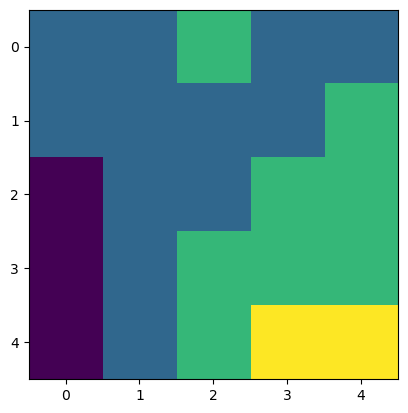

In [271]:
gray1 = np.average(img_rgbir_crop, axis=0).astype('uint8')
display(gray1)
plt.imshow(gray1)

Version 2

Equation taken from "Experimental analysis of sand grain size mapping using UAV remote sensing" - Bae et. al 2019

array([[201, 202, 202, 202, 202],
       [201, 202, 202, 202, 202],
       [201, 201, 202, 202, 203],
       [201, 201, 202, 203, 203],
       [201, 201, 203, 203, 203]], dtype=uint8)

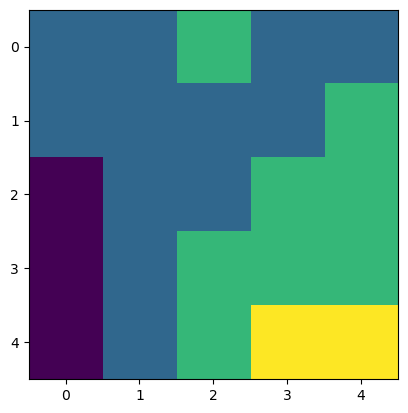

In [272]:
gray2 = np.average(img_rgbir_crop, axis=0, weights=[0.3, 0.59, 0.11, 0.]).astype('uint8')
display(gray2)
plt.imshow(gray1)

Marchetti et. al (2021), and Black et. al (2014) both used a range of 33, 51 and 101 kernel window size. For a 2cm/px resolution this roughly equates to 0.6m, 1m and 2m
For a 0.6m/px resolution (NAIP), this roughly equates to 1, 2 and 3px respectively

In [279]:
glcm1 = graycomatrix(gray1, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)
glcm2 = graycomatrix(gray2, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)

In [280]:
dis1, dis2 = graycoprops(glcm1, 'dissimilarity'), graycoprops(glcm2, 'dissimilarity')

Average the directional values, but keep the offsets?

In [254]:
np.average(dis1, axis=1)

array([1.06973761, 1.41640853, 4.90744055])

In [281]:
np.average(dis1, axis=1)

array([0.478125  , 0.665625  , 0.91666667])

In [282]:
hom1, hom2 = graycoprops(glcm1, 'homogeneity'), graycoprops(glcm2, 'homogeneity')

In [283]:
np.average(hom1, axis=1)

array([0.7609375 , 0.6771875 , 0.59888889])

In [284]:
graycoprops(glcm1, 'homogeneity'), graycoprops(glcm2, 'homogeneity')

(array([[0.75      , 0.65625   , 0.825     , 0.8125    ],
        [0.57333333, 0.65625   , 0.66666667, 0.8125    ],
        [0.52      , 0.51111111, 0.62      , 0.74444444]]),
 array([[0.81      , 0.7625    , 0.9       , 0.84375   ],
        [0.60666667, 0.7625    , 0.76666667, 0.84375   ],
        [0.45      , 0.48888889, 0.65      , 0.66666667]]))

In [201]:
graycoprops(glcm1, 'correlation'), graycoprops(glcm2, 'correlation')

(array([[0.83997342, 0.81546982, 0.83997342, 0.78860864],
        [0.57552922, 0.56364951, 0.57552922, 0.57868155],
        [0.35362115, 0.45170162, 0.35362115, 0.42805627]]),
 array([[0.78412023, 0.69421195, 0.78412023, 0.6724742 ],
        [0.47387806, 0.40706961, 0.47387806, 0.44100117],
        [0.31314112, 0.29074111, 0.31314112, 0.29938078]]))

In [202]:
graycoprops(glcm1, 'contrast'), graycoprops(glcm2, 'contrast')

(array([[19.23012301, 22.76587659, 19.23012301, 25.61737374],
        [49.4964934 , 53.36592409, 49.4964934 , 49.78850359],
        [72.91415515, 67.94625177, 72.91415515, 65.68036685]]),
 array([[ 8.5339534 , 11.99919992,  8.5339534 , 12.80767677],
        [20.83941832, 22.88242574, 20.83941832, 21.44923461],
        [27.30878033, 27.8539876 , 27.30878033, 27.18851902]]))

In [203]:
graycoprops(glcm1, 'energy'), graycoprops(glcm2, 'energy')

(array([[0.12949347, 0.13072891, 0.12949347, 0.12991075],
        [0.12221552, 0.12068431, 0.12221552, 0.12345767],
        [0.11460225, 0.11161909, 0.11460225, 0.11751046]]),
 array([[0.21521808, 0.21871392, 0.21521808, 0.21764814],
        [0.19830012, 0.19690465, 0.19830012, 0.20568737],
        [0.1853504 , 0.18241216, 0.1853504 , 0.19629454]]))

# Closing Notes

To do the equivalent of what [ee.Image.glcmTexture](https://developers.google.com/earth-engine/apidocs/ee-image-glcmtexture) does in GEE, i.e. use a sliding window to compute the texture features for the entire masked sandy areas, follow [this post](https://stackoverflow.com/questions/42459493/sliding-window-in-python-for-glcm-calculation)

Also check [this out](https://stackoverflow.com/questions/35551249/implementing-glcm-texture-feature-with-scikit-image-and-python)